In [1]:
# 1. Import packages
import os,keras,cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from keras import layers,losses,callbacks,activations,regularizers,metrics,applications,optimizers

In [6]:
# 2. Data loading
PATH = os.path.join("Concrete Crack Images for Classification")

BATCH_SIZE = 32
IMG_SIZE = (160,160)

train_dataset,validation_dataset = keras.utils.image_dataset_from_directory(PATH,shuffle=True,validation_split=0.3,
                                                         batch_size=BATCH_SIZE,subset='both',
                                                         image_size=IMG_SIZE,seed=40)

Found 40000 files belonging to 2 classes.
Using 28000 files for training.
Using 12000 files for validation.


['Negative', 'Positive']


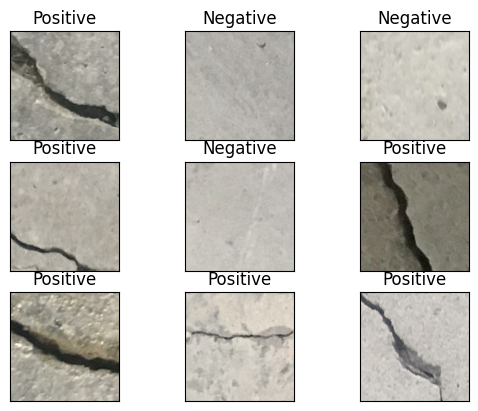

In [7]:
# 3. Inspect some data samples from the dataset
class_names = train_dataset.class_names
print(class_names)
batch_1 = train_dataset.take(1)
for feature,label in batch_1:
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(feature[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
plt.show()

In [8]:
# 4 Split the validation and test dataset
nBatches = validation_dataset.cardinality().numpy()
print(nBatches)
val_dataset = validation_dataset.take(nBatches * 0.7)
test_dataset = validation_dataset.skip(nBatches//2)

375


In [10]:
# 5 Convert the dataset back to PrefetchDataset
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
# 6. Create a sequential model for augmentation
data_augmentation = keras.Sequential()
data_augmentation.add(layers.RandomFlip())
data_augmentation.add(layers.RandomRotation(factor=0.2))

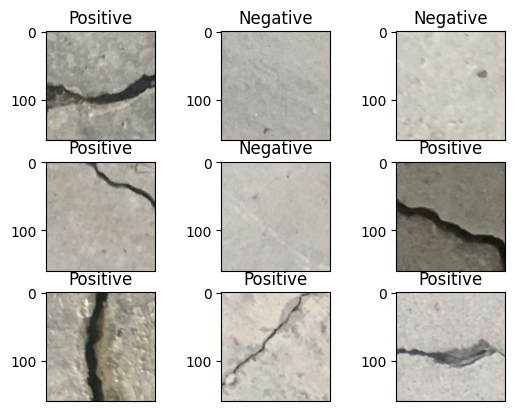

In [12]:
features_augmented = data_augmentation(feature)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(features_augmented[i].numpy().astype('uint8'))
    plt.title(class_names[label[i]])
    plt.xticks([])
    plt.grid(False)
plt.show()

In [28]:
# Create the preprocessing layer based on the pretrained model
preprocess_input = applications.mobilenet_v2.preprocess_input

In [29]:
# 7. Apply transfer learning
# (A) Load in the pretrained model as feature extractor
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
#Freeze the entire feature extractor to make sure we only train the classifier
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:
# (B) Construct the classifier
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(len(class_names),activation='softmax')

In [44]:
# (C) Use functional API to connect all the layers together
#a. Begin with the input
inputs = keras.Input(shape=IMG_SHAPE)
# b. Augmentation layers
x = data_augmentation(inputs)
#c.preprocessing layer
x = preprocess_input(x)
#d. Feature extractor
x = base_model(x)
#e. Classifier
x = global_avg(x)
outputs = output_layer(x)
#f. Create the model
model = keras.Model(inputs=inputs,outputs=outputs)
model.summary()
keras.utils.plot_model(model)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_5 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_5 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [32]:
# 8. Compile the model
optimizer = optimizers.Adam(learning_rate=0.0001)
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

In [33]:
# 9. Train the model
logpath = os.path.join("transfer_learning_log",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(logpath)
tb = callbacks.TensorBoard(log_dir=logpath)
es = callbacks.EarlyStopping(patience=3,verbose=1)

transfer_learning_log\20250312-121156


In [34]:
#Evaluate the model before training
model.evaluate(test_dataset)

188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 148ms/step - accuracy: 0.5173 - loss: 1.3129


[1.3295845985412598, 0.513464093208313]

In [35]:
#Proceed with the training
EPOCHS = 10
history_first = model.fit(train_dataset,validation_data=val_dataset,epochs=EPOCHS,callbacks=[tb,es])

Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 172s 192ms/step - accuracy: 0.9130 - loss: 0.2439 - val_accuracy: 0.9967 - val_loss: 0.0187
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 161s 184ms/step - accuracy: 0.9962 - loss: 0.0163 - val_accuracy: 0.9980 - val_loss: 0.0100
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 160s 183ms/step - accuracy: 0.9962 - loss: 0.0114 - val_accuracy: 0.9982 - val_loss: 0.0073
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 160s 183ms/step - accuracy: 0.9968 - loss: 0.0088 - val_accuracy: 0.9986 - val_loss: 0.0061
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 163s 186ms/step - accuracy: 0.9979 - loss: 0.0069 - val_accuracy: 0.9984 - val_loss: 0.0055
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 165s 188ms/step - accuracy: 0.9978 - loss: 0.0068 - val_accuracy: 0.9984 - val_loss: 0.0049
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 162s 185ms/step - accuracy: 0.9987 - loss: 0.0053 - val_accuracy: 0.9988 - val_loss: 0.0042
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 162s 185ms/step - accuracy: 0.9982 -

In [36]:
# Evaluate the model after the first stage training
model.evaluate(test_dataset)

188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.9992 - loss: 0.0043


[0.00422710133716464, 0.9988364577293396]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step
['Negative', 'Positive', 'Positive', 'Negative', 'Negative', 'Positive', 'Positive', 'Negative', 'Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Negative', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive']


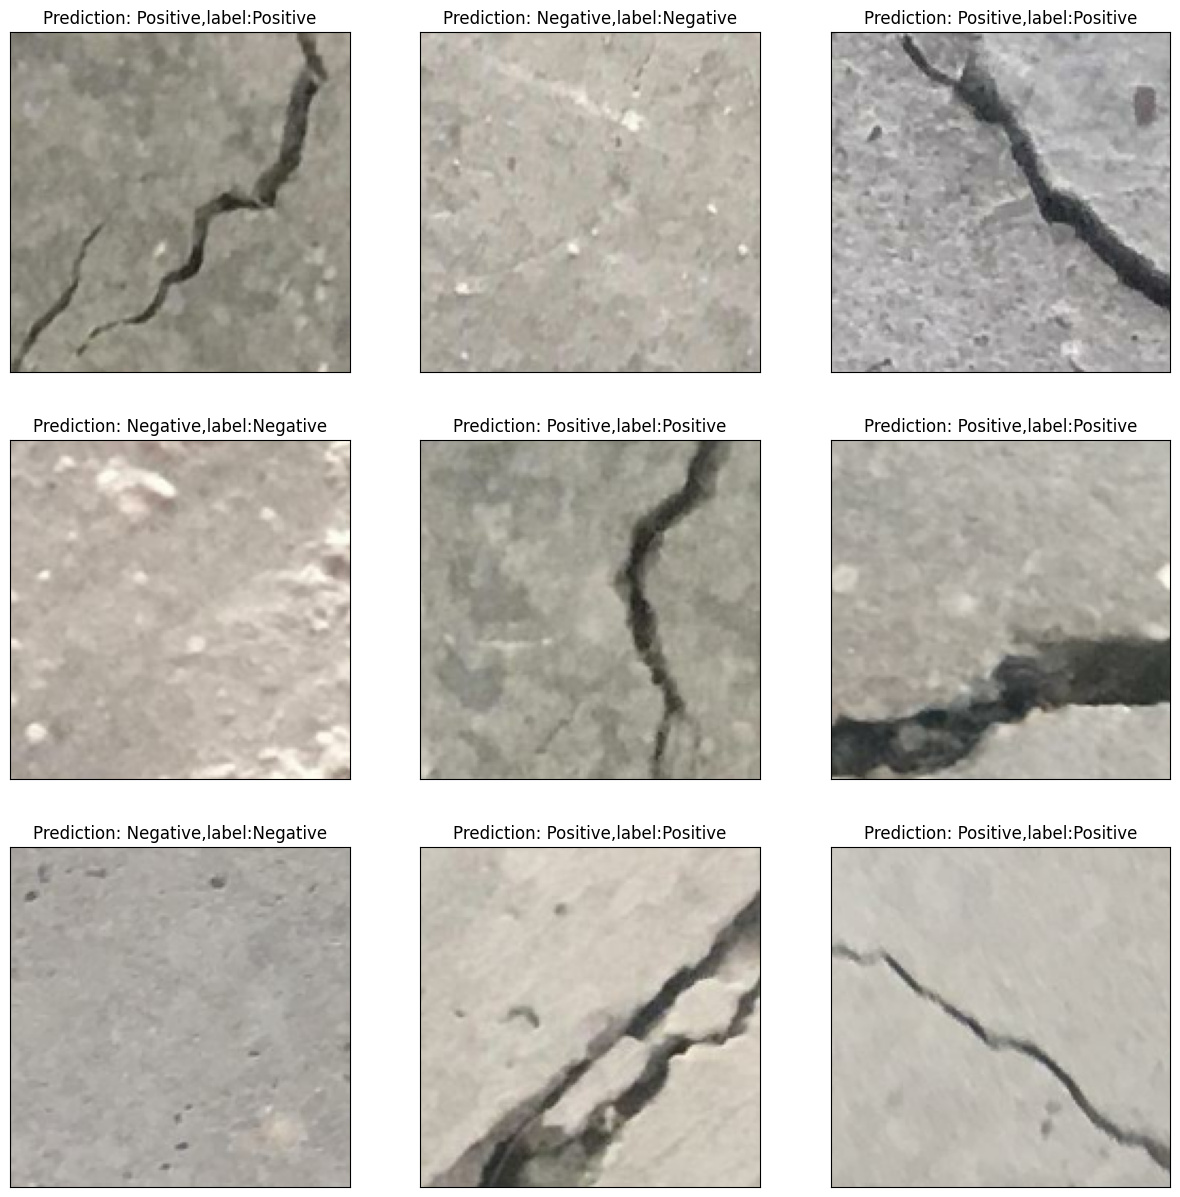

In [37]:
#Use the model to make prediction
for image_batch,label_batch in test_dataset.take(1):
    y_pred = np.argmax(model.predict(image_batch),axis=1)
    predicted_class = [class_names[x] for x in y_pred]
print(predicted_class)

plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i+9].numpy().astype('uint8'))
    plt.title(f"Prediction: {predicted_class[i+9]},label:{class_names[label_batch[i+9]]}")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

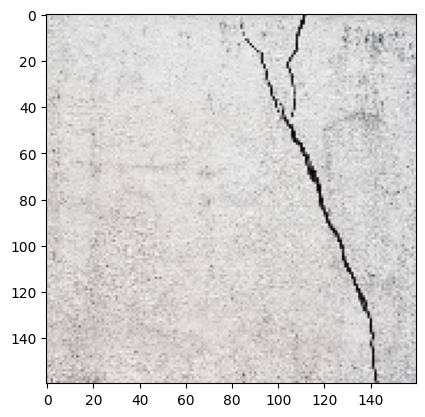

(160, 160, 3)
(1, 160, 160, 3)


In [38]:
#Use the model to predict with a random image
img = cv2.imread(filename="Img/concrete.jpg",flags=cv2.IMREAD_COLOR_RGB)
#img = cv2.cvtColor(img,code=cv2.COLOR_BGR2BGR)
img = cv2.resize(img,dsize=(160,160))
plt.imshow(img)
plt.show()
print(img.shape)
img = np.expand_dims(img,axis=0)
print(img.shape)

In [39]:
prediction = model.predict(img)
class_names[np.argmax(prediction,axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step


'Positive'

In [41]:
# Save Model
model.save("model/model.keras")